In [1]:
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.dml import CausalForestDML
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [14]:
import pandas as pd

# 1. Causal Forest: Heterogeneous causal effects with no unobserved confounders


In [2]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [3]:
np.random.seed(123)
n_samples = 2000
n_features = 10
n_treatments = 1

In [4]:
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:,[0]], np.ones((X.shape[0], n_treatments -1)) * np.arange(1,n_treatments).reshape(1,-1)])

In [5]:
true_te

<function __main__.<lambda>>

In [26]:
X = np.random.normal(0, 1, size = (n_samples, n_features))

T = np.random.normal(0, 1, size = (n_samples, n_treatments))
for t in range(n_treatments):
    T[:,t] = np.random.binomial(1, scipy.special.expit(X[:,0]))

In [27]:
y = np.sum(true_te(X) * T, axis = 1, keepdims = True) + np.random.normal(0, 0.5, size = (n_samples,1))

In [38]:
X_test = X[:min(100, n_samples)].copy()

X_test[:,0] = np.linspace(np.percentile(X[:, 0], 1), 
                          np.percentile(X[:,0],99), 
                          min(100,n_samples))

In [40]:
est = CausalForest(
    criterion = 'het', 
    n_estimators = 400, 
    min_samples_leaf = 5,
    max_depth = None,
    min_var_fraction_leaf = None,
    min_var_leaf_on_val = True,
    min_impurity_decrease = 0.0, 
    max_samples = 0.45, min_balancedness_tol = 0.45,
    warm_start = False, inference = True, fit_intercept = True, subforest_size = 4,
    honest = True, verbose = 0, n_jobs = -1, random_state = 1235)

In [41]:
est.fit(X, T, y)

CausalForest(criterion='het', min_var_leaf_on_val=True, n_estimators=400,
             random_state=1235)

In [53]:
point, lb, ub = est.predict(X_test, interval = True, alpha = 0.01)

In [54]:
point = est.predict(X_test)

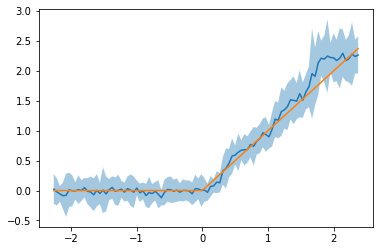

In [55]:
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:,t])
    if est.inference:
        plt.fill_between(X_test[:,0], lb[:,t], ub[:,t], alpha = 0.4)
    plt.plot(X_test[:,0], true_te(X_test)[:,t])
plt.show()

In [47]:
import shap

In [48]:
est1 = CausalForestDML(cv=2,
                      criterion='mse', n_estimators=400,
                      min_var_fraction_leaf=0.1,
                      min_var_leaf_on_val=True,
                      verbose=0, discrete_treatment=False,
                      n_jobs=-1, random_state=123)
est1.fit(y, T, X=X)

In [58]:
res = est1.const_marginal_effect_inference(X_test)
point1 = res.point_estimate
lb1, ub1 = res.conf_int(alpha=0.01)

In [63]:
point1.shape

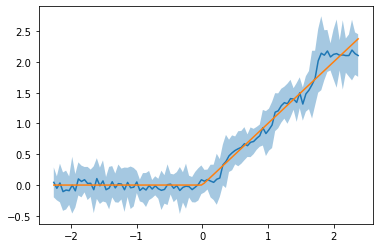

In [66]:
n_outputs = 1
for t in range(n_treatments):
    for j in range(n_outputs):
        plt.plot(X_test[:, 0], point1[:, j, t])
        plt.fill_between(X_test[:,0], lb1[:, j, t], ub1[:, j, t], alpha=.4)
        plt.plot(X_test[:, 0], (j + 1) * true_te(X_test)[:, t])
plt.show()

# 2. Causal IV Forest: Heterogeneous causal effects with unobserved confounders